In [1]:

import mediapipe as mp
import os
import matplotlib.pyplot as plt

In [2]:
BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path="../models/pose_landmarker_lite.task"),
    running_mode=VisionRunningMode.IMAGE)

landmarker = PoseLandmarker.create_from_options(options)  

In [6]:
mp_image = mp.Image.create_from_file('../data/Pose/Bad Angle-samples/0.jpg')
landmark_results = landmarker.detect(mp_image)
landmark_results.pose_landmarks[0][0]

c:\Users\patel\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


NormalizedLandmark(x=0.47534850239753723, y=0.40751123428344727, z=-2.094233512878418, visibility=0.9999427795410156, presence=0.9998762607574463)

## Load all data

In [7]:
import numpy as np
from tqdm import tqdm


In [8]:
pose_dirs = ["Good Angle-samples", "Bad Angle-samples"]
pose_data = []
pose_labels = []


for dir in pose_dirs:
  pose_data_path = os.path.join(r"..\data\Pose", dir)
  for image in tqdm(os.listdir(pose_data_path)):
    try:
      image_path = os.path.join(pose_data_path, image)
      mp_image = mp.Image.create_from_file(image_path)

      landmark_results = landmarker.detect(mp_image)
      pose_landmarks = landmark_results.pose_landmarks[0]
      landmark_np = []
      for landmark in pose_landmarks:
        landmark_x = landmark.x
        landmark_y = landmark.y
        landmark_z = landmark.z
        landmark_viz = landmark.visibility
        landmark_presence = landmark.presence
        
        landmark_np.append([landmark_x, landmark_y, landmark_z, landmark_viz, landmark_presence])
      pose_data.append(landmark_np)
      pose_labels.append(dir)
    except:
      print(image)

 55%|█████▌    | 195/354 [00:08<00:06, 23.06it/s]

270.jpg
272.jpg


100%|██████████| 354/354 [00:15<00:00, 22.86it/s]


In [9]:
pose_data = np.array(pose_data)
pose_data_reshaped = pose_data.reshape(-1,pose_data.shape[1]*pose_data.shape[2])

In [10]:
from sklearn.preprocessing import OneHotEncoder
pose_lable_ohe = OneHotEncoder(handle_unknown="infrequent_if_exist")
pose_labels_one_hot = pose_lable_ohe.fit_transform(np.array(pose_labels).reshape(-1,1)).toarray()

In [11]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(pose_data_reshaped, pose_labels_one_hot, shuffle=True)

In [12]:
xtrain.shape, ytrain.shape

((437, 165), (437, 2))

In [13]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [14]:
model = Sequential()
model.add(
  Dense(
    input_shape=[165],
    units=100,
    activation="relu"
  )
)
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=['accuracy'])

c:\Users\patel\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,802 (65.63 KB)

 Trainable params: 16,802 (65.63 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(xtrain, ytrain, epochs=50, shuffle=True, validation_split=0.2)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5154 - loss: 0.8980 - val_accuracy: 0.7273 - val_loss: 0.5407
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6543 - loss: 0.6176 - val_accuracy: 0.7727 - val_loss: 0.4685
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7695 - loss: 0.4981 - val_accuracy: 0.8523 - val_loss: 0.4328
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8048 - loss: 0.4864 - val_accuracy: 0.8409 - val_loss: 0.3906
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8502 - loss: 0.4082 - val_accuracy: 0.8636 - val_loss: 0.3905
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8351 - loss: 0.4150 - val_accuracy: 0.8295 - val_loss: 0.3370
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8354 - loss: 0.3887 - val_accuracy: 0.7955 - val_loss: 0.4215
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8318 - loss: 0.3593 - val_accuracy: 0.8636 - val_loss

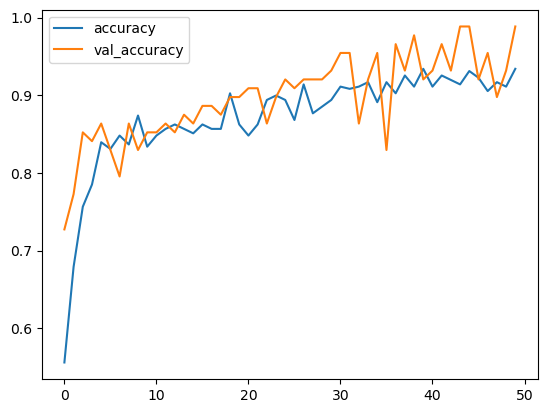

In [17]:
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()


In [18]:
model.evaluate(xtest, ytest)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9441 - loss: 0.1337 


[0.13673749566078186, 0.9520547986030579]

In [19]:
test_preds = model.predict(xtest)
test_preds_rounded = test_preds.argmax(axis=1)
ytest_argmax = ytest.argmax(axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [21]:
pose_lable_ohe.inverse_transform([[0.0,1.0]])

array([['Good Angle-samples']], dtype='<U18')

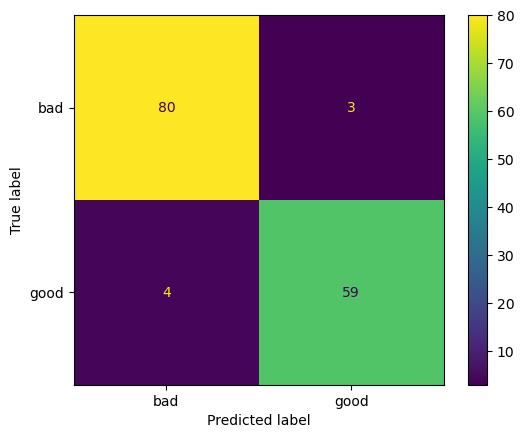

In [22]:
cm = confusion_matrix(ytest_argmax, test_preds_rounded)
cm_d = ConfusionMatrixDisplay(cm, display_labels=['bad','good'])
cm_d.plot()
plt.show()

In [57]:
model.save_weights("../models/pose_model_0.95.weights.h5")

In [59]:
def test_new_image(image_path):
  mp_image = mp.Image.create_from_file(image_path)
  landmark_results = landmarker.detect(mp_image)
  landmarks = landmark_results.pose_landmarks[0]
  arr = []
  
  plt.imshow(mp_image.numpy_view())
  plt.show()
  
  for landmark in landmarks:
    landmark_x = landmark.x
    landmark_y = landmark.y
    landmark_z = landmark.z
    landmark_viz = landmark.visibility
    landmark_presence = landmark.presence
    
    arr.extend([landmark_x, landmark_y, landmark_z, landmark_viz, landmark_presence])
  arr = np.array([arr])
  
  preds = model.predict(arr).round()
  print(np.argmax(preds, axis=1).squeeze())
  preds = pose_lable_ohe.inverse_transform(preds)
  print(preds)

c:\Users\patel\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


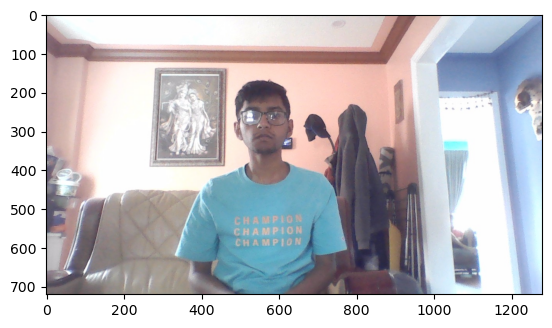

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1
[['Good Angle-samples']]


c:\Users\patel\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


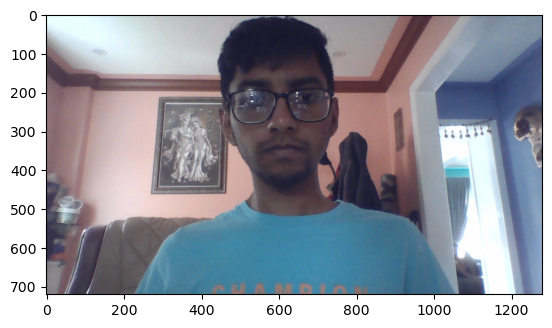

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1
[['Good Angle-samples']]


c:\Users\patel\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


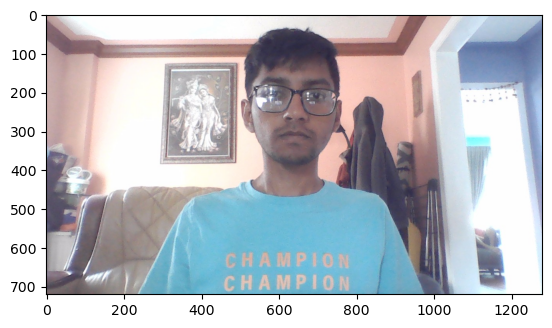

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1
[['Good Angle-samples']]


c:\Users\patel\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


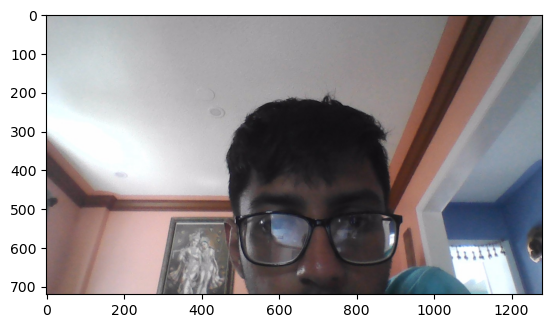

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
0
[['Bad Angle-samples']]


In [60]:
test_new_image(r"..\data\Pose\test-3.jpg")
test_new_image(r"..\data\Pose\test-2.jpg")
test_new_image(r"..\data\Pose\test-4.jpg")
test_new_image(r"..\data\Pose\test.jpg")
